# UB NN Training
## Loading Dataset

In [1]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Val.csv'


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Input1,Input2,Input3,Output
0,2.659116,4.673695,1.231898,-1.010633
1,6.172297,0.308095,6.197296,0.140169
2,1.620350,3.752477,3.010036,0.014108
3,6.269573,3.173038,6.019555,-0.016590
4,3.946378,3.264015,2.245954,1.222183


## Loading Similarity Information

In [2]:
import pickle as pkl

fileName =  '../input/a1-data-to-similar-events/Similarity'
fileObject2 = open(fileName, 'rb')
Imported_data = pkl.load(fileObject2)
fileObject2.close()

#print('Similarity Thresholds:',Imported_data[:,0])

#print('Most Similarity at:',Imported_data[:,1])

Similar_event_count = len(Imported_data[0,:])-1
print('Number of Similar Samples Considered', Similar_event_count)

Similarity_thresholds = Imported_data[:,0]

Sample_density = Similar_event_count/ Similarity_thresholds/100
#Sample_density = number of samples with less than 1% (of range) deviation

Similar_samples = Imported_data[:,1:Similar_event_count+1]

print('Target Shape', Sample_density.shape, 'Similar Samples Matrix Shape:', Similar_samples.shape)

input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])

Number of Similar Samples Considered 100
Target Shape (5000,) Similar Samples Matrix Shape: (5000, 100)


## Load UB Correction Model

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

PATH = '../input/a4-bound-correction-nn-training/best_model.pt'

num_input = 1
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x
net_load = Net(n_feature=num_input, n_hidden=400, n_output=1)     # define the network
#net_load = net_load.to(device)

net_load.load_state_dict(torch.load(PATH))



<All keys matched successfully>

In [4]:
Uncertainty_Bound = torch.tensor(0.80) # The expected UB

f = open('../input/a4-bound-correction-nn-training/min_x.pckl', 'rb')
min_UBx = pkl.load(f)
f.close()

f = open('../input/a4-bound-correction-nn-training/max_x.pckl', 'rb')
max_UBx = pkl.load(f)
f.close()

Uncertainty_Bound = (Uncertainty_Bound-min_UBx)/(max_UBx-min_UBx) # Normalizing

new_shape = (Uncertainty_Bound.shape[0], 1)
Uncertainty_Bound = Uncertainty_Bound.view(new_shape)

Uncertainty_Bound_corrected = net_load(Uncertainty_Bound)

f = open('../input/a4-bound-correction-nn-training/min_y.pckl', 'rb')
min_UBy = pkl.load(f)
f.close()

f = open('../input/a4-bound-correction-nn-training/max_y.pckl', 'rb')
max_UBy = pkl.load(f)
f.close()

Uncertainty_Bound_corrected = Uncertainty_Bound_corrected*(max_UBy-min_UBy)+min_UBy # DeNormalizing

print(Uncertainty_Bound_corrected)


tensor([[0.7771]], grad_fn=<AddBackward0>)


## Applying Corrected UB to Traditional System

In [5]:
higher_count=0;
bound_values = []
for iter1 in range(len(output_)):
    indexes=Similar_samples[iter1];
    Probability_density =[]
    for iter2 in indexes:
        Probability_density.append(output_[iter2.astype(np.int64)])
    Probability_density = np.sort(Probability_density)
    prediction_bound = Probability_density[np.round(Similar_event_count*Uncertainty_Bound_corrected.detach().numpy()).astype(np.int64)-1]
    bound_values.append(prediction_bound)
    if prediction_bound > output_[iter1]:
        higher_count = higher_count + 1;
        
print('Statistical UB location:', higher_count/len(output_))

Statistical UB location: 0.8326


## Data Preparation for NN Training

In [6]:
x=[]
y=[]
i_val=[]
o_val=[]
for iter1 in range(len(output_)):
    if iter1%10==0:
        x.append(input_[iter1])
        y.append(bound_values[iter1])
        continue
    i_val.append(input_[iter1])
    o_val.append(bound_values[iter1])

x = torch.tensor(x).float()  
y = torch.tensor(y).float() 

new_shape = (len(y), 1)
y = y.view(new_shape)
print('Shapes:', x.shape, y.shape)

i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)


max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

Shapes: torch.Size([500, 3]) torch.Size([500, 1])
tensor(1.1881) tensor(-0.9380) tensor([6.2637, 6.2746, 6.2580]) tensor([0.0004, 0.0108, 0.0018])
tensor([6.2633, 6.2638, 6.2561]) tensor(2.1260)


##  NN Training for Direct Input to UB

In [7]:
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
num_input=3
 
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

    
# use the same net as before      
net = Net(n_feature=num_input, n_hidden=400, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


minimum_train_loss = 1e5
minimum_val_loss = 1e5
EPOCH = 1000

# start training
for epoch in range(EPOCH):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt = net
    
    if epoch%200 == 199:
        prediction = net_opt(i_val)
        loss_val = loss_func(prediction, o_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt
        print ("Epoch [{}/{}], Loss: {:.4f}, Minimum Loss {:.6f}, Val Loss {:.6f}  "  .format(epoch+1, EPOCH, loss, minimum_train_loss, minimum_val_loss))

Net(
  (hidden): Linear(in_features=3, out_features=400, bias=True)
  (hidden2): Linear(in_features=400, out_features=400, bias=True)
  (predict): Linear(in_features=400, out_features=1, bias=True)
)
Epoch [200/1000], Loss: 0.0148, Minimum Loss 0.014272, Val Loss 0.023042  
Epoch [400/1000], Loss: 0.0093, Minimum Loss 0.008274, Val Loss 0.016393  
Epoch [600/1000], Loss: 0.0059, Minimum Loss 0.005879, Val Loss 0.014506  
Epoch [800/1000], Loss: 0.0049, Minimum Loss 0.004933, Val Loss 0.013531  
Epoch [1000/1000], Loss: 0.0041, Minimum Loss 0.004082, Val Loss 0.012427  


## Statistical performance of NN on Training Set

In [8]:
higher_count=0;

for iter1 in range(len(output_)):
    Net_input = torch.tensor(input_[iter1]).float() 
    Net_input = (Net_input - min_x.values)/range_x # Normalizing
    
    prediction_bound = net_opt_val(Net_input) # Apply Net
    
    prediction_bound = prediction_bound*range_y+min_y # Denormalizing    
    
    if prediction_bound > output_[iter1]:
        higher_count = higher_count + 1;
        
print('Statistical UB location for Direct NN:', higher_count/len(output_))

Statistical UB location for Direct NN: 0.8166


## Statistical performance of NN on Validation Set

In [9]:
input_=[]
output_=[]
val_df = pd.read_csv(val_csv_path)

for row in val_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
higher_count=0;

for iter1 in range(len(output_)):
    Net_input = torch.tensor(input_[iter1]).float() 
    Net_input = (Net_input - min_x.values)/range_x # Normalizing
    
    prediction_bound = net_opt_val(Net_input) # Apply Net
    
    prediction_bound = prediction_bound*range_y+min_y # Denormalizing    
    
    if prediction_bound > output_[iter1]:
        higher_count = higher_count + 1;
        
print('Statistical UB location for Direct NN:', higher_count/len(output_))

Statistical UB location for Direct NN: 0.811


## Statistical performance of NN on Test Set

In [10]:
input_ = []
output_ = []
test_df = pd.read_csv(test_csv_path)

for row in test_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
higher_count=0;
prediction_ = []
x_0 = []

for iter1 in range(len(output_)):
    x_in = input_[iter1]
    x_0.append(x_in[0])
    Net_input = torch.tensor(x_in).float() 
    Net_input = (Net_input - min_x.values)/range_x # Normalizing
    
    prediction_bound = net_opt_val(Net_input) # Apply Net
    
    prediction_bound = prediction_bound*range_y+min_y # Denormalizing    
    prediction_.append(float(prediction_bound))
    if prediction_bound > output_[iter1]:
        higher_count = higher_count + 1;
        
print('Statistical UB location for Direct NN:', higher_count/len(output_))

Statistical UB location for Direct NN: 0.802


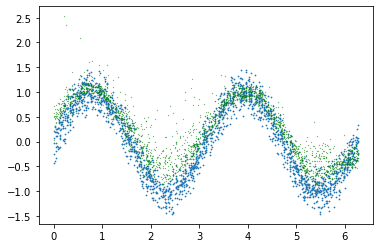

In [11]:
plt.scatter(x_0,output_, s=0.5)
plt.scatter(x_0, prediction_, color='g', s=0.05) # lower boundary prediction
plt.show()